# Population Fisher estimates for a gaussian toy model

The purpose of this code is to check the precision attained with Fisher estimates from a Fisher Information Matrix for population parameters. We choose to work with a $\textbf{simple gaussian model}$, in such a way that the Fisher estimates can be obtained analytically. 

The MCMC results can be obtained in a separate notebook and are simply loaded here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import matplotlib as mpl
import seaborn as sns
import pickle


%matplotlib inline
np.random.seed(1234)

In [2]:
# Nice plotting options.

params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

### Fisher estimates for case I (no selection effects)

We load the MCMC results here.

In [3]:
with open('data_files/mu_samples_N=1e5.pickle', 'rb') as handle:
    mu_samples = pickle.load(handle)
with open('data_files/Sigma2_samples_N=1e5.pickle', 'rb') as handle:
    Sigma2_samples = pickle.load(handle)

Here we report the true values and other global parameters used in the loaded simulations.

In [4]:
N_obs = 100000
true_mu = 0.5
true_Sigma_sq = 1.5
Sigma = np.sqrt(true_Sigma_sq)
sigma = 0.2
std = np.sqrt(Sigma**2 + sigma**2)
data  = np.random.normal(true_mu,std,size=N_obs)

We need the model used to plot our Fisher predictions against the MCMC results.

In [5]:
def model(d,mu,Sigma_sq):
    
    """
    Model for p(d|lambda).
    
    Input:
    
    - data              (The noisy generated data where we expect theta to be.)
    - mu                (First  hyperparameter, "param[0]" in MCMC initialization.)
    - Sigma^2 + sigma^2 (Second hyperparameter, "param[1]" in MCMC initialization.)
    
    """
    num = np.exp(-0.5*(d-mu)**2/Sigma_sq)
    den = np.sqrt(2*np.pi*Sigma_sq)
    return num/den

The Fisher matrix for the simple Gaussian case without selection effects is found to be

$$
\Gamma_\lambda = \begin{pmatrix}
\Gamma_{\mu\mu} & \Gamma_{\mu\Sigma^2}\\
\Gamma_{\mu\Sigma^2} & \Gamma_{\Sigma^2\Sigma^2}
\end{pmatrix}
$$

with 

$$
\Gamma_{\mu\mu}= \frac{1}{\sigma^2+\Sigma^2}, \quad \Gamma_{\mu\Sigma^2} = 0,\quad \Gamma_{\Sigma^2\Sigma^2} = \frac{1}{2(\sigma^2+\Sigma^2)^2}.
$$

In [6]:
Gamma_mu_mu = 1/(sigma**2 + true_Sigma_sq)
Gamma_Ssq_Ssq = 0.5*1/(sigma**2 + true_Sigma_sq)**2

Gamma_lambda = [[Gamma_mu_mu,0],[0,Gamma_Ssq_Ssq]]
Gamma_lambda_inv = np.linalg.inv(Gamma_lambda)

To match the width from the MCMC results we need to normalize the Fisher matrix results by the number of observed events (the $N^{-1/2}$) factor. That is because the matrix is derived for an individual observation, while the MCMC results are obtained with $N$-long data arrays.

In [7]:
Dlambda_diag = 1/np.sqrt(N_obs) *  np.sqrt(np.diag(Gamma_lambda_inv)) #renormalization.
Dmu, DSigma_sq = Dlambda_diag[0], Dlambda_diag[1]

We can check that the Fisher estimates agree with the variance of the samples, and more directly against the posterior distributions. 

FM widths [0.00392428 0.00688709]
MCMC widths: [0.00392395, 0.00694604]


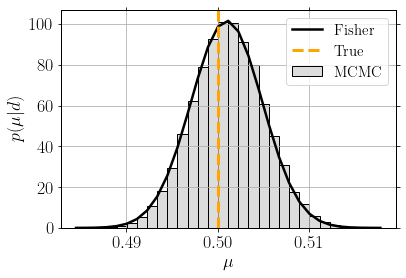

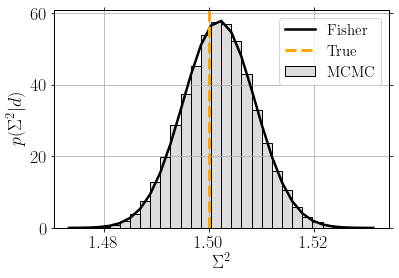

In [8]:
print('FM widths',Dlambda_diag)
print('MCMC widths:',[np.round(np.sqrt(np.var(mu_samples)),8),np.round(np.sqrt(np.var(Sigma2_samples)),8)])


"""
Posteriors with Fisher estimates
"""

truths=[true_mu, true_Sigma_sq]

_, bins_mu, _= plt.hist(mu_samples, 30, histtype = 'bar',
                               color ='gainsboro', density=True, edgecolor='black', label='MCMC')

bins_mu= np.array(bins_mu)
plt.plot(bins_mu, model(bins_mu,true_mu + 0.001,Dmu**2), color='black', lw=2.5, label='Fisher')

plt.axvline(x=truths[0], label='True', c='orange',ls='--',lw=3)
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|d)$')
plt.legend()
plt.show()

_, bins_Ssq, _=plt.hist(Sigma2_samples, 30, histtype = 'bar',
                        color ='gainsboro', density=True, edgecolor='black', 
                        label='MCMC')

bins_Ssq= np.array(bins_Ssq)
plt.plot(bins_Ssq, model(bins_Ssq,true_Sigma_sq+0.002,DSigma_sq**2), color='black', 
         lw=2.5,label='Fisher')

plt.axvline(x=truths[1], label='True', c='orange',ls='--', lw=3)
plt.xlabel('$\Sigma^2$')
plt.ylabel('$p(\Sigma^2|d)$')
plt.legend()
plt.show()

### Fisher estimates for case II (with selection effects)

Load data for MCMC results with selection effects.

In [9]:
with open('data_files/mu_samples_selbias_N=1e5.pickle', 'rb') as handle:
    mu_samples_selbias = pickle.load(handle)
with open('data_files/Sigma2_samples_selbias_N=1e5.pickle', 'rb') as handle:
    Sigma2_samples_selbias = pickle.load(handle)

Specify the same threshold used in the MCMC analysis.

In [10]:
d_th = 0.5 #threshold for data.

data_sel_bias = data[data > d_th]
N_det = len(data_sel_bias)

print('Number detected events:', N_det)

Number detected events: 49932


In the Fisher matrix with selection effects we will make use of the following definitions defined just below,

$$
    p_\text{det}(\lambda) = \frac{1}{2}\text{erfc}\left[\frac{d_\text{th}-\mu}{\sqrt{2(\sigma^2+\Sigma^2)}}\right], \quad p(d_\text{th}|\lambda) = \frac{1}{\sqrt{2\pi (\sigma^2+\Sigma^2)}} \exp\left[-\frac{(d_\text{th}-\mu)^2}{2(\sigma^2+\Sigma^2)}\right]
$$

In [11]:
from scipy.special import erfc

# Useful definitions

sigmasq_plus_Sigmasq =  sigma**2 + true_Sigma_sq
pdet_lambda_true = 0.5 * erfc((d_th - true_mu)/np.sqrt(2 * sigmasq_plus_Sigmasq))
pof_dth_lambda = np.exp(-0.5* (d_th - true_mu)**2/sigmasq_plus_Sigmasq)/np.sqrt(2*np.pi * sigmasq_plus_Sigmasq)

The Fisher matrix is now defined as

$$
\Gamma_\lambda = \begin{pmatrix}
\Gamma_{\mu\mu} & \Gamma_{\mu\Sigma^2}\\
\Gamma_{\mu\Sigma^2} & \Gamma_{\Sigma^2\Sigma^2}
\end{pmatrix}
$$

with 

$$
\Gamma_{\mu\mu}= \frac{1}{\sigma^2+\Sigma^2} + \frac{\partial^2 \ln p_\text{det}(\lambda)}{\partial \mu^2}, \quad \Gamma_{\mu\Sigma^2} = \frac{1}{\sigma^2+\Sigma^2} \frac{p(d_\text{th}|\lambda)}{p_\text{det}(\lambda)} + \frac{\partial^2 \ln p_\text{det}(\lambda)}{\partial \mu\Sigma^2},\\
\Gamma_{\Sigma^2\Sigma^2} = \frac{1}{2(\sigma^2+\Sigma^2)^2}\frac{(d_\text{th}-\mu)}{(\sigma^2+\Sigma^2)^2}\frac{p(d_\text{th}|\lambda)}{p_\text{det}(\lambda)}+ \frac{\partial^2 \ln p_\text{det}(\lambda)}{\partial \Sigma^2\Sigma^2}.
$$


The expressions as coded up below have been manipulated with $\texttt{Mathematica}$.

In [12]:
dpdet_dmu_sq = (d_th - true_mu) * pof_dth_lambda /sigmasq_plus_Sigmasq /pdet_lambda_true - pof_dth_lambda**2 / pdet_lambda_true**2
dpdet_dmudSigmasq = 0.5 * pof_dth_lambda *  (d_th**2 - 2 * d_th * true_mu + true_mu**2 - sigmasq_plus_Sigmasq)/ sigmasq_plus_Sigmasq**2/pdet_lambda_true -0.5 * pof_dth_lambda**2 / pdet_lambda_true**2 * (d_th - true_mu)/ sigmasq_plus_Sigmasq
dpdet_dSigmasq_sq = 1./4. * (d_th - true_mu) * pof_dth_lambda* (d_th**2 - 2 * d_th * true_mu + true_mu**2 -3* sigmasq_plus_Sigmasq)/sigmasq_plus_Sigmasq**3/pdet_lambda_true - 1./4.* pof_dth_lambda**2 / pdet_lambda_true**2 * (d_th - true_mu)**2/ sigmasq_plus_Sigmasq**2


In [13]:
Gamma_mu_mu_selbias = 1/sigmasq_plus_Sigmasq + dpdet_dmu_sq
Gamma_mu_Ssq_selbias = 1/sigmasq_plus_Sigmasq * pof_dth_lambda/pdet_lambda_true + dpdet_dmudSigmasq
Gamma_Ssq_Ssq_selbias = 0.5 * 1/sigmasq_plus_Sigmasq**2 + (d_th - true_mu)/sigmasq_plus_Sigmasq**2 * pof_dth_lambda/pdet_lambda_true + dpdet_dSigmasq_sq 


Build up the Fisher matrix.

In [14]:
Gamma_lambda_selbias =[[Gamma_mu_mu_selbias,Gamma_mu_Ssq_selbias],[Gamma_mu_Ssq_selbias,Gamma_Ssq_Ssq_selbias]]
Gamma_lambda_selbias_inv = np.linalg.inv(Gamma_lambda_selbias)

And normalize it by the number of observed events (NOT the underlying population).

In [15]:
Dlambda_diag_selbias = 1/np.sqrt(N_det) *  np.sqrt(np.diag(Gamma_lambda_selbias_inv))
Dmu_selbias, DSigma_sq_selbias = Dlambda_diag_selbias[0], Dlambda_diag_selbias[1]

We can check that the Fisher estimates agree with the variance of the samples, and more directly against the posterior distributions. 

FM widths [0.02615926 0.02767461]
MCMC widths: [0.0245714, 0.0261802]


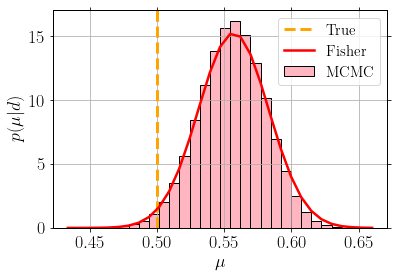

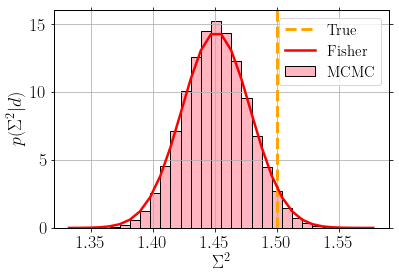

In [16]:
print('FM widths',Dlambda_diag_selbias)
print('MCMC widths:',[np.round(np.sqrt(np.var(mu_samples_selbias)),8),np.round(np.sqrt(np.var(Sigma2_samples_selbias)),8)])


"""
Posteriors with Fisher estimates
"""


# Mean

plt.axvline(x=truths[0], label='True', c='orange',linestyle='--',lw=3)
_, bins_selbias_mu, _= plt.hist(mu_samples_selbias, 30, histtype = 'bar',
                               color ='lightpink', density=True, edgecolor='black', label='MCMC')
bins_selbias_mu= np.array(bins_selbias_mu)
plt.plot(bins_selbias_mu, model(bins_selbias_mu,true_mu+0.057,Dmu_selbias**2),
         color='red', lw=2.5, label='Fisher')

plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|d)$')
plt.legend()
plt.show()

# Variance

plt.axvline(x=truths[1], label='True', c='orange',linestyle='--',lw=3)
_, bins_selbias_Ssq, _=plt.hist(Sigma2_samples_selbias, 30, histtype = 'bar',
                               color ='lightpink', density=True, edgecolor='black', label='MCMC')
bins_selbias_Ssq= np.array(bins_selbias_Ssq)
plt.plot(bins_selbias_Ssq, model(bins_selbias_Ssq,true_Sigma_sq-0.049,DSigma_sq_selbias**2), 
         color='red', lw=2.5, label='Fisher')

plt.xlabel('$\Sigma^2$')
plt.ylabel('$p(\Sigma^2|d)$')
plt.legend()
plt.show()